# Quick Start Tutorial

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomaly detection.

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:

* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* A number of pre-built models
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

## Datasets

### Provided datasets

GluonTS comes with a number of publicly available datasets.

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly']


To download one of the built-in datasets, simply call get_dataset with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [4]:
dataset = get_dataset("m4_hourly")

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

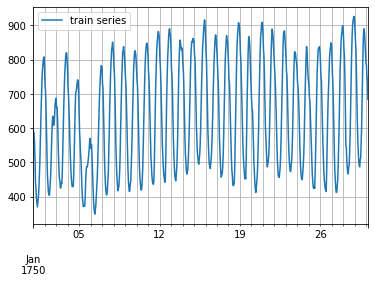

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

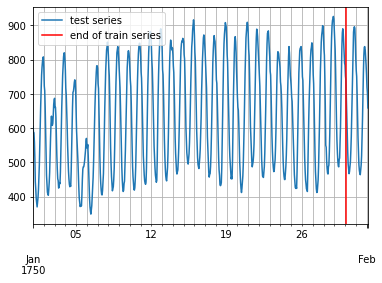

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Custom datasets

At this point, it is important to emphasize that GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Period` (possibly different for each time series):

In [8]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

Now, you can split your dataset and bring it in a GluonTS appropriate format with just two lines of code:

In [9]:
from gluonts.dataset.common import ListDataset

In [10]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in custom_dataset],
    freq=freq
)

## Training an existing model (`Estimator`)

GluonTS comes with a number of pre-built models. All the user needs to do is configure some hyperparameters. The existing models focus on (but are not limited to) probabilistic forecasting. Probabilistic forecasts are predictions in the form of a probability distribution, rather than simply a single point estimate.

We will begin with GulonTS's pre-built feedforward neural network estimator, a simple but powerful forecasting model. We will use this model to demonstrate the process of training a model, producing forecasts, and evaluating the results.

GluonTS's built-in feedforward neural network (`SimpleFeedForwardEstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the feedforward neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [11]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

In [12]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        ctx="cpu", 
        epochs=5, 
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    )
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to construct forecasts.

In [13]:
predictor = estimator.train(dataset.train)

  0%|                                                                                               | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.84it/s, epoch=1/5, avg_epoch_loss=5.52]

  0%|                                                                                               | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████| 100/100 [00:01<00:00, 97.34it/s, epoch=2/5, avg_epoch_loss=4.96]

  0%|                                                                                               | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████| 100/100 [00:01<00:00, 96.97it/s, epoch=3/5, avg_epoch_loss=4.69]

  0%|                                                                                               | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████| 100/100 [00:01<00:00, 99.51it/s, epoch=4/5, avg_epoch_loss=4.74]

  0%|                                                                                               | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████| 100/100 [00:01<00:00, 96.84it/s, epoch=5/5, avg_epoch_loss=4.75]

## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the `dataset.test` and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The module outputs the forecast sample paths and the `dataset.test` (as python generator objects)

In [14]:
from gluonts.evaluation import make_evaluation_predictions

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series of `dataset.test`.

In [17]:
# first entry of the time series list
ts_entry = tss[0]

In [18]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [20]:
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

The entries in the `forecast` list are a bit more complex. They are objects that contain all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [21]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [22]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


We can also do calculations to summarize the sample paths, such computing the mean or a quantile for each of the 48 time steps in the forecast window.

In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [636.38965 572.4451  536.3801  450.12863 528.2869  409.64246 420.2701
 493.45148 501.92355 592.41895 734.28564 750.54474 665.63617 751.3235
 804.0946  850.76373 852.19867 869.5502  808.7402  963.85406 758.48517
 653.4814  682.02734 671.6107  692.8256  529.7951  540.8719  510.67303
 585.3563  410.13434 510.55417 460.30832 419.06122 564.2022  689.7244
 742.6515  693.4881  787.705   876.1771  885.452   837.9125  903.38556
 932.9774  812.0785  858.8974  783.37646 656.0206  728.7835 ]
0.5-quantile (median) of the future window:
 [629.08655 588.052   529.8576  436.8228  521.4028  420.9239  407.04398
 514.9176  497.41943 599.31085 709.81915 762.25433 684.2913  749.3914
 785.725   853.986   920.8516  875.2325  818.1829  961.1764  760.5606
 652.46954 671.2017  664.1626  685.10333 532.65405 558.9082  510.68195
 569.67426 410.06537 505.9936  453.70956 421.91092 568.3355  680.79193
 728.18726 695.9792  788.5569  865.3332  885.6238  842.0535  917.46783
 924.06244 819.778

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [24]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

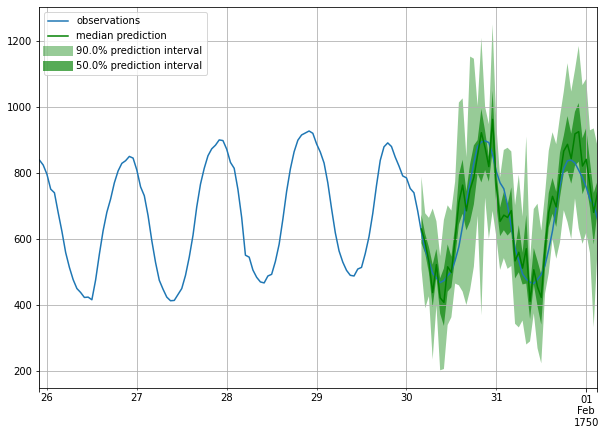

In [25]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [26]:
from gluonts.evaluation import Evaluator

In [27]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation:   0%|                                                                           | 0/414 [00:00<?, ?it/s]

Running evaluation: 100%|███████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 5129.68it/s]

Aggregate metrics aggregate both across time-steps and across time series.

In [28]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 13353581.906147957,
    "abs_error": 11459462.406002045,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 4.882731862399929,
    "MAPE": 0.2773778969586953,
    "sMAPE": 0.20995117344814024,
    "MSIS": 70.14657575262561,
    "QuantileLoss[0.1]": 6085254.0098073,
    "Coverage[0.1]": 0.09435386473429955,
    "QuantileLoss[0.5]": 11459462.367041588,
    "Coverage[0.5]": 0.47071256038647324,
    "QuantileLoss[0.9]": 7654547.267381571,
    "Coverage[0.9]": 0.8717290660225446,
    "RMSE": 3654.2553148552656,
    "NRMSE": 0.49888656603251125,
    "ND": 0.07872734179571321,
    "wQuantileLoss[0.1]": 0.0418061384880421,
    "wQuantileLoss[0.5]": 0.07872734152805203,
    "wQuantileLoss[0.9]": 0.052587297524093295,
    "mean_absolute_QuantileLoss": 8399754.54807682,
    "mean_wQuantileLoss": 0.057706925846729144,
    "MAE_Coverage": 0.0210681696188942,
    "OWA": NaN
}


Individual metrics are aggregated only across time-steps.

In [29]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,4342.188151,2514.812012,31644.0,659.250000,42.371302,1.236495,0.082673,0.080927,0.079472,14.448329,1231.586359,0.000000,2514.811859,0.562500,1558.627032,0.958333
1,1.0,164508.302083,16701.164062,124149.0,2586.437500,165.107988,2.107354,0.142632,0.130051,0.134525,15.914876,3763.655518,0.145833,16701.164795,0.895833,8935.006982,1.000000
2,2.0,43759.885417,8240.220703,65030.0,1354.791667,78.889053,2.176110,0.118799,0.127338,0.126714,15.710191,4048.258252,0.000000,8240.221191,0.187500,3664.808093,0.750000
3,3.0,289310.458333,21805.435547,235783.0,4912.145833,258.982249,1.754097,0.091619,0.093280,0.092481,17.029197,11473.986719,0.020833,21805.435303,0.437500,9689.282812,0.895833
4,4.0,88446.875000,12454.733398,131088.0,2731.000000,200.494083,1.294171,0.096439,0.092423,0.095010,13.430941,4931.936755,0.000000,12454.733276,0.625000,7710.477246,1.000000


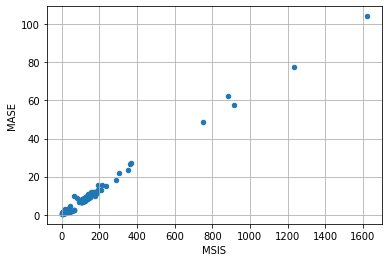

In [30]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()